# Test projections

In [1]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_angle/fiber_00',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

def compute_projection_values(num_points,attenuation_values,lengths):
    I0 = 1
    # Compute the spacing between ray points
    dx = lengths / (num_points)

    # Compute the sum of mu * dx along each ray
    attenuation_sum = torch.sum(attenuation_values * dx[:,None], dim=1)

    # Compute the intensity at the detector using the Beer-Lambert Law
    intensity = I0 * torch.exp(-attenuation_sum)
    
    # Inverse the intensity to make it look like CT
    return I0-intensity

In [2]:
datamodule = CTDataModule(args_dict)
datamodule.setup("fit")

Generating points from rays: 100%|██████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.31s/it]


  0%|                                                                                        | 0/16 [00:00<?, ?it/s]

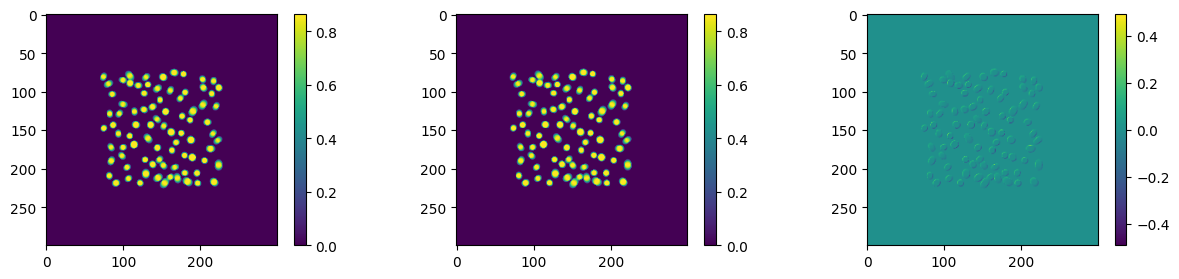

  6%|█████                                                                           | 1/16 [00:17<04:28, 17.87s/it]

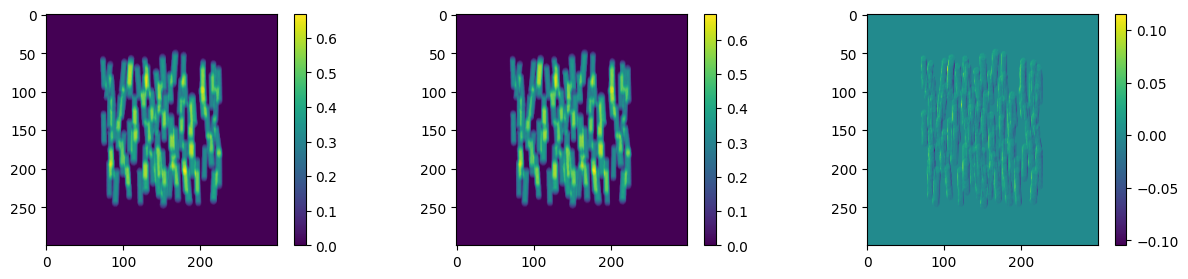

 12%|██████████                                                                      | 2/16 [00:35<04:07, 17.68s/it]

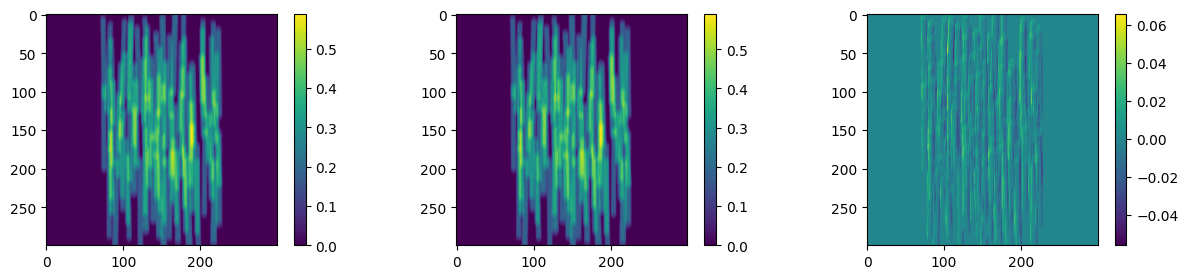

 19%|███████████████                                                                 | 3/16 [00:53<03:52, 17.91s/it]

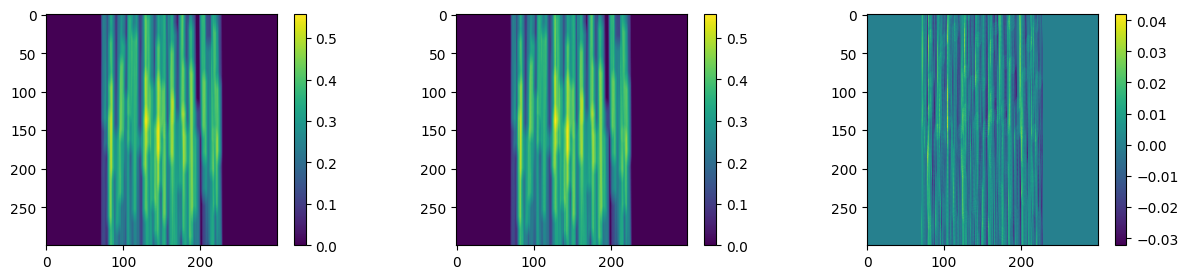

 25%|████████████████████                                                            | 4/16 [01:11<03:36, 18.02s/it]

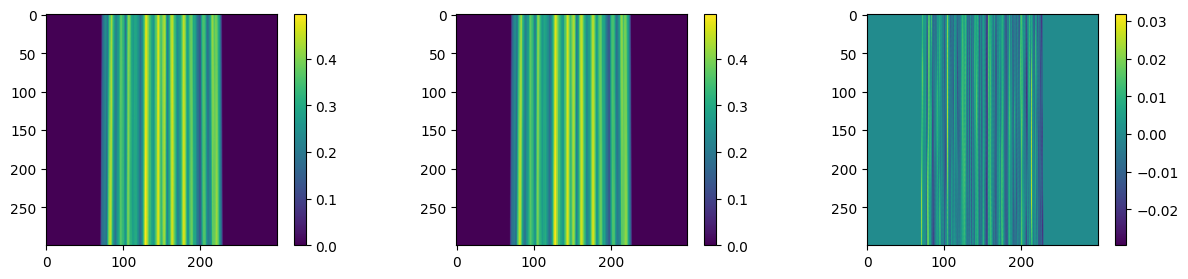

 31%|█████████████████████████                                                       | 5/16 [01:30<03:19, 18.10s/it]

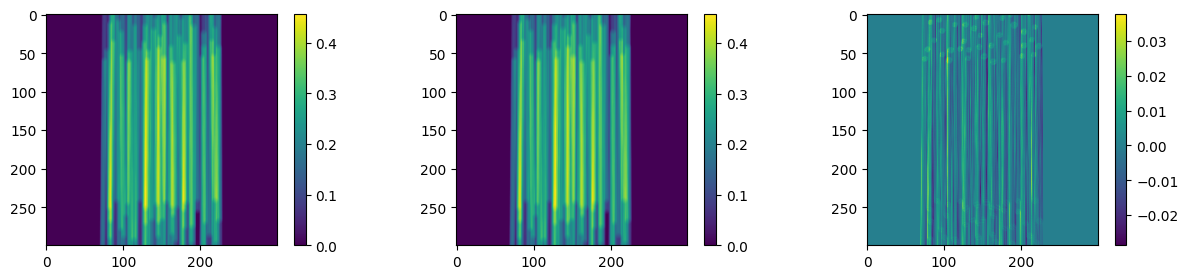

 38%|██████████████████████████████                                                  | 6/16 [01:48<03:01, 18.11s/it]

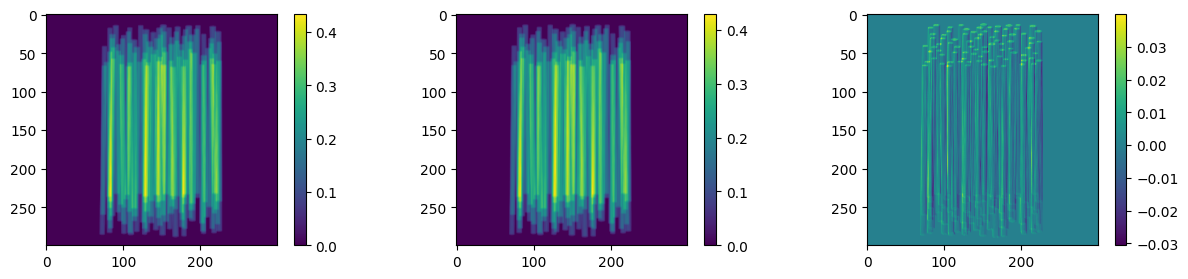

 44%|███████████████████████████████████                                             | 7/16 [02:05<02:41, 17.97s/it]

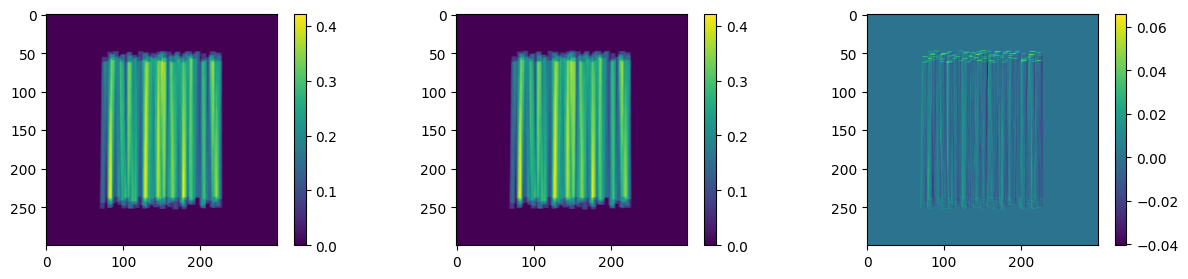

 50%|████████████████████████████████████████                                        | 8/16 [02:23<02:22, 17.76s/it]

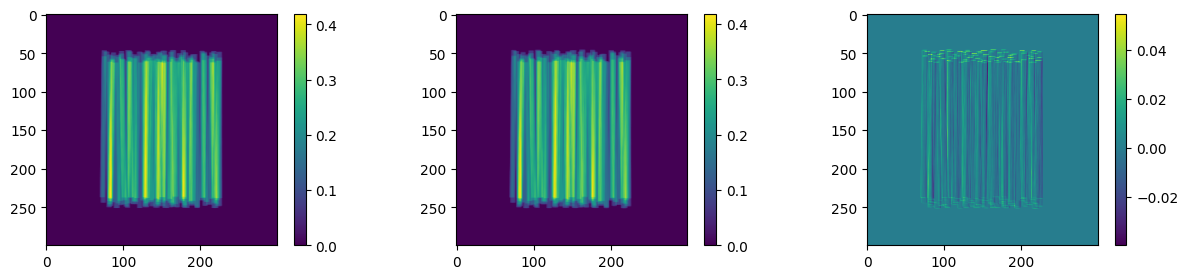

 56%|█████████████████████████████████████████████                                   | 9/16 [02:40<02:03, 17.68s/it]

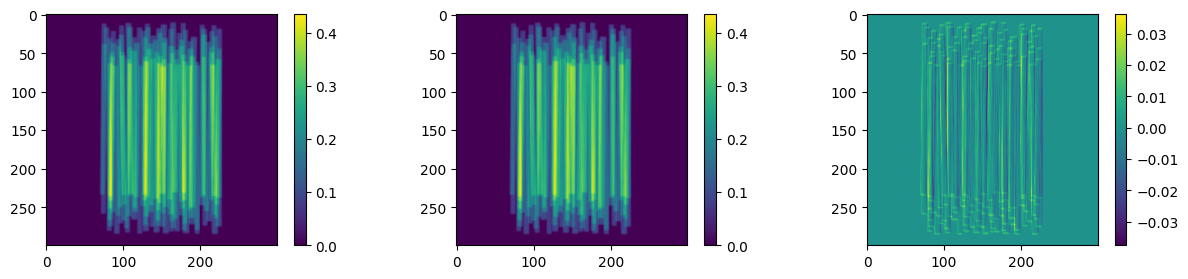

 62%|█████████████████████████████████████████████████▍                             | 10/16 [02:58<01:46, 17.71s/it]

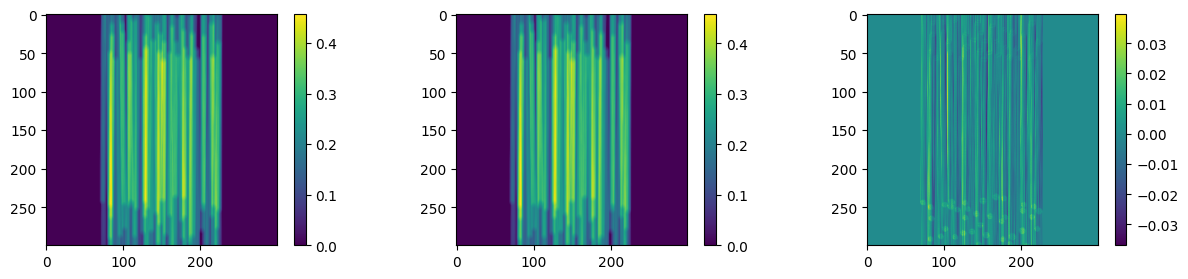

 69%|██████████████████████████████████████████████████████▎                        | 11/16 [03:16<01:29, 17.88s/it]

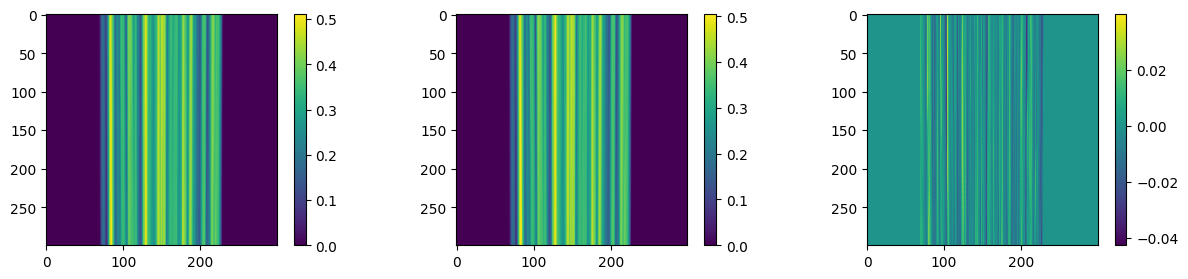

 75%|███████████████████████████████████████████████████████████▎                   | 12/16 [03:34<01:11, 17.97s/it]

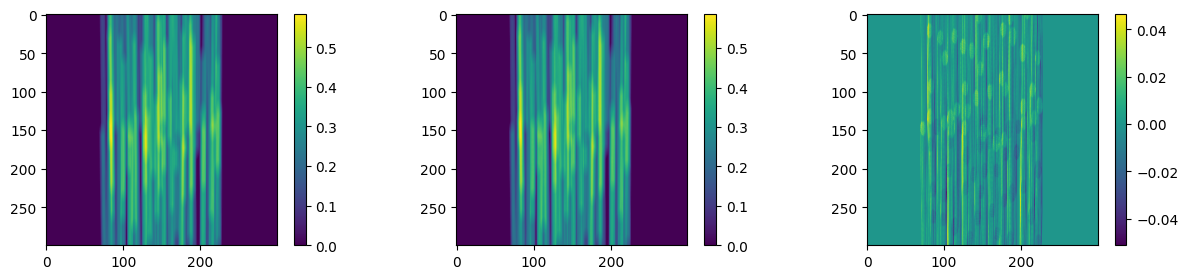

 81%|████████████████████████████████████████████████████████████████▏              | 13/16 [03:53<00:54, 18.10s/it]

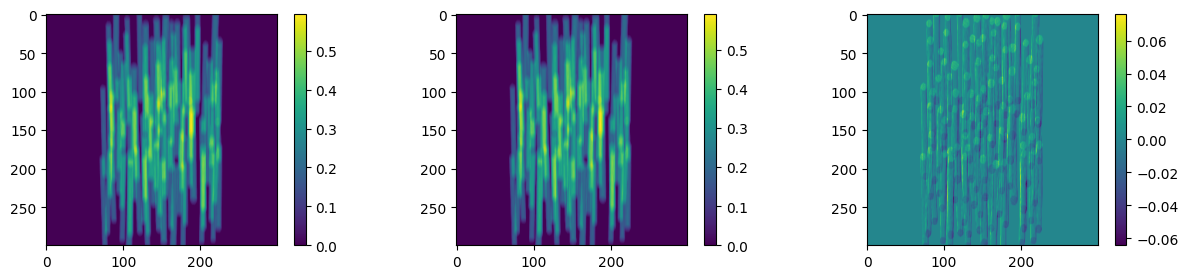

 88%|█████████████████████████████████████████████████████████████████████▏         | 14/16 [04:11<00:36, 18.12s/it]

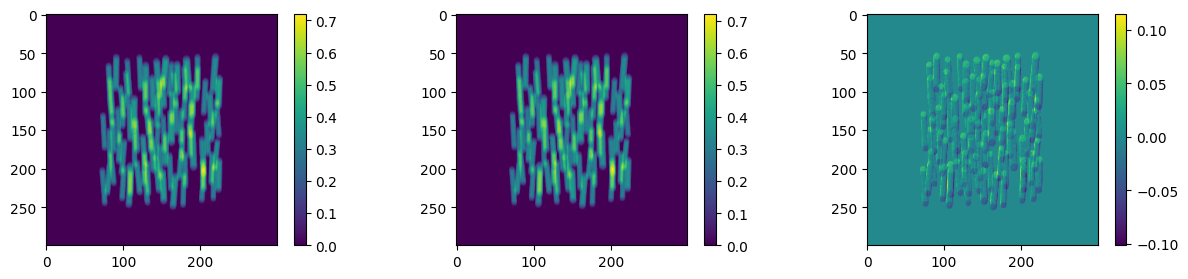

 94%|██████████████████████████████████████████████████████████████████████████     | 15/16 [04:29<00:18, 18.07s/it]

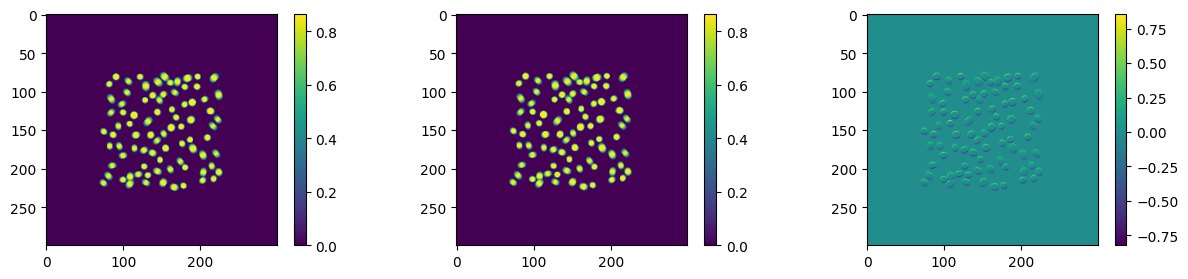

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [04:46<00:00, 17.92s/it]


In [3]:
img = datamodule.dataset.img.numpy()

grid = (np.linspace(0, img.shape[0]-1, img.shape[0]),np.linspace(0, img.shape[1]-1, img.shape[1]),np.linspace(0, img.shape[2]-1, img.shape[2]))
for i in tqdm(range(16)):
    projection_shape = datamodule.dataset.projections.shape
    points = datamodule.dataset.points[(projection_shape[1]*projection_shape[2])*i:(projection_shape[1]*projection_shape[2])*(i+1),:,:]
    lengths = datamodule.dataset.lengths[(projection_shape[1]*projection_shape[2])*i:(projection_shape[1]*projection_shape[2])*(i+1)]
    attenuation_values = scipy.interpolate.interpn(grid,img,(points*(img.shape[2]//2)+(img.shape[2]//2)),bounds_error=False,fill_value=0)
    
    detector_value_hat = compute_projection_values(points.shape[1],torch.tensor(attenuation_values),lengths)
    detector_value_hat = detector_value_hat.view(img.shape[0],img.shape[1]).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    mine = ax[0].imshow(detector_value_hat)
    astra = ax[1].imshow(datamodule.dataset.projections[i,:,:])
    diff = ax[2].imshow(datamodule.dataset.projections[i,:,:]-detector_value_hat)
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

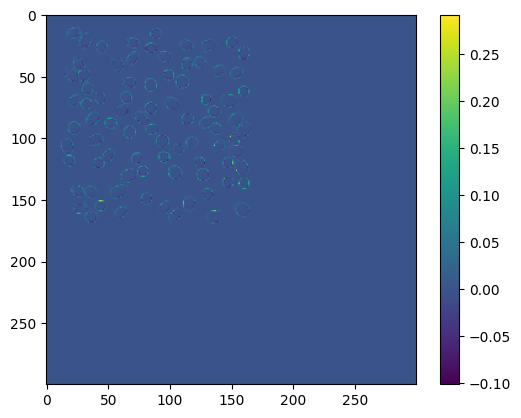

In [4]:
# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_angle/walnut',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}
datamodule = CTDataModule(args_dict)
datamodule.setup("fit")

In [ ]:
img = datamodule.dataset.img.numpy()

grid = (np.linspace(0, img.shape[0]-1, img.shape[0]),np.linspace(0, img.shape[1]-1, img.shape[1]),np.linspace(0, img.shape[2]-1, img.shape[2]))
for i in tqdm(range(16)):
    projection_shape = datamodule.dataset.projections.shape
    points = datamodule.dataset.points[(projection_shape[1]*projection_shape[2])*i:(projection_shape[1]*projection_shape[2])*(i+1),:,:]
    lengths = datamodule.dataset.lengths[(projection_shape[1]*projection_shape[2])*i:(projection_shape[1]*projection_shape[2])*(i+1)]
    attenuation_values = scipy.interpolate.interpn(grid,img,(points*(img.shape[2]//2)+(img.shape[2]//2)),bounds_error=False,fill_value=0)
    
    detector_value_hat = compute_projection_values(points.shape[1],torch.tensor(attenuation_values),lengths)
    detector_value_hat = detector_value_hat.view(img.shape[0],img.shape[1]).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    mine = ax[0].imshow(detector_value_hat)
    astra = ax[1].imshow(datamodule.dataset.projections[i,:,:])
    diff = ax[2].imshow(datamodule.dataset.projections[i,:,:]-detector_value_hat)
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

# Test trained model

In [1]:
import numpy as np
import tifffile
from tqdm import tqdm
import scipy.ndimage as ndi

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP
from src import get_device, _PATH_DATA, _PATH_MODELS

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_angle/walnut',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [2]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()
# loader = datamodule.dataloader_for_testing()

In [3]:
projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=projection_shape[::2]
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/walnut_angle-2024-07-03-2253/MLP-epoch=74.ckpt"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_28240/3466268605.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], stric

In [4]:
img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
img -= img.min()
img = img/img.max()
img = img.permute(2,1,0)
tifffile.imwrite("real_img.tif",(img.numpy()*255).astype("uint8"))

In [5]:
mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[2]), indexing='ij'),dim=-1)
mgrid = mgrid.view(-1,img.shape[2],3)
outputs = torch.zeros((*mgrid.shape[:2],1))
for i in tqdm(range(mgrid.shape[1])):
    with torch.no_grad():
        output = model(mgrid[:,i,:].cuda())
    outputs[:,i,:] = output.cpu()

100%|█████████████████████████████████████████████████████████████████████████████| 410/410 [00:10<00:00, 40.46it/s]


In [6]:
outputs = outputs.view(img.shape)

In [7]:
print(outputs.min())
print(outputs.max())

tensor(-0.0289)
tensor(0.2014)


In [8]:
outputs -= outputs.min()
outputs /= outputs.max()

In [9]:
tifffile.imwrite("reconstruction_mlp.tif",(outputs.numpy()*255).astype("uint8"))

# Testing

In [2]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt
from glob import glob
import os

from mpl_toolkits.mplot3d import Axes3D

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_angle/fiber_00',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

def compute_projection_values(num_points,attenuation_values,lengths):
    I0 = 1
    # Compute the spacing between ray points
    dx = lengths / (num_points)

    # Compute the sum of mu * dx along each ray
    attenuation_sum = torch.sum(attenuation_values * dx[:,None], dim=1)

    # Compute the intensity at the detector using the Beer-Lambert Law
    intensity = I0 * torch.exp(-attenuation_sum)
    
    # Inverse the intensity to make it look like CT
    return I0-intensity

In [3]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()

In [143]:
class Geometry(torch.nn.Module):
    def __init__(self,source_pos,detector_pos,detector_size,detector_pixel_size,object_shape,beam_type="cone"):
        """
        Parameters
        ----------
        source_pos : torch.Tensor
            ray source position x,y,z position in relation to sample
        detector_pos : torch.Tensor
            center of detector x,y,z position in relation to sample
        detector_size : Sequence[int]
            Shape of detector in pixels e.g. (300,300)
        detector_pixel_size : Sequence[torch.Tensor]
            Two vectors defining the size of the pixels 
            u : the vector from detector pixel (0,0) to (0,1)
            v : the vector from detector pixel (0,0) to (1,0)
        object_shape: Sequence[int]
            shape of object in um, i.e. an object which has the dimensions 200x200x300um has the shape [200,200,300]
        beam_type : str
            Which beam type to use for calculating projection. Default 'cone'
        """
        super(Geometry, self).__init__()
        self.source_pos = source_pos
        self.detector_pos = detector_pos
        self.detector_size = detector_size
        self.detector_pixel_size = detector_pixel_size
        self.u_vec = detector_pixel_size[:3]
        self.v_vec = detector_pixel_size[3:]
        self.beam_type = beam_type
        self.object_shape = object_shape

        # Convert into relative coordinates 
        self.source_pos[0] /= self.object_shape[0]/2
        self.source_pos[1] /= self.object_shape[1]/2
        self.source_pos[2] /= self.object_shape[2]/2
        
        self.detector_pos[0] /= self.object_shape[0]/2
        self.detector_pos[1] /= self.object_shape[1]/2
        self.detector_pos[2] /= self.object_shape[2]/2
        
        self.u_vec[0] /= self.object_shape[0]/2
        self.u_vec[1] /= self.object_shape[1]/2
        self.u_vec[2] /= self.object_shape[2]/2

        self.v_vec[0] /= self.object_shape[0]/2
        self.v_vec[1] /= self.object_shape[1]/2
        self.v_vec[2] /= self.object_shape[2]/2
        

        self.detector_pixel_coordinates = self.create_grid(self.detector_pos, self.u_vec, self.v_vec, self.detector_size[0],self.detector_size[1])
        
        self.ray_directions()

        self.start_points, self.end_points, self.valid_indices = self.ray_sphere_intersections(self.source_pos.repeat(self.detector_size[0]*self.detector_size[1]).view(-1,3),self.rays.view(-1,3),torch.zeros(3),torch.sqrt(torch.tensor(3.)))

        self.start_points[~self.valid_indices] = self.source_pos
        self.end_points[~self.valid_indices] = self.detector_pixel_coordinates.view(-1,3)[~self.valid_indices]


    def detector_coordinates(self):
        x_component = self.u_vec*(self.detector_size[0]/2)
        y_component = self.v_vec*(self.detector_size[1]/2)
        
        bottom_left_corner = self.detector_pos - x_component - y_component
        bottom_left_corner_pixel_pos = bottom_left_corner + self.u_vec/2 + self.v_vec/2 #Something weird here I would expect it to be self.u_vec/2 + self.v_vec/2

        detector_pixel_coordinates = torch.zeros((self.detector_size[0],self.detector_size[1],3))

        if self.detector_size[0] == self.detector_size[1]:
            for i in range(self.detector_size[0]):
                detector_pixel_coordinates[:,i,0] = torch.arange(0,self.detector_size[0])
                detector_pixel_coordinates[i,:,1] = torch.arange(0,self.detector_size[1])
                detector_pixel_coordinates[:,i,2] = torch.arange(0,self.detector_size[0])
                detector_pixel_coordinates[i,:,2] = torch.arange(0,self.detector_size[1])
        else:
            for i in range(self.detector_size[1]):
                detector_pixel_coordinates[:,i,0] = torch.arange(0,self.detector_size[0])
            for i in range(self.detector_size[0]):
                detector_pixel_coordinates[i,:,1] = torch.arange(0,self.detector_size[1])
        
        self.detector_pixel_coordinates = (detector_pixel_coordinates * self.u_vec + detector_pixel_coordinates * self.v_vec)+bottom_left_corner_pixel_pos
    
    def ray_directions(self):
        self.rays = (self.detector_pixel_coordinates - self.source_pos)
        lengths = torch.linalg.norm(self.rays,dim=2)
        self.rays[:,:,0] = self.rays[:,:,0] / lengths
        self.rays[:,:,1] = self.rays[:,:,1] / lengths
        self.rays[:,:,2] = self.rays[:,:,2] / lengths

    def ray_sphere_intersections(self,ray_origins, ray_directions, sphere_center, sphere_radius):
        """
        Calculates the intersection points between rays and a sphere using PyTorch tensors.
        
        Args:
            ray_origins (torch.Tensor): Tensor of 3D coordinates of ray origins (shape: (n, 3)).
            ray_directions (torch.Tensor): Tensor of 3D vectors representing ray directions (shape: (n, 3)).
            sphere_center (torch.Tensor): 3D coordinates of the sphere center.
            sphere_radius (float): Radius of the sphere.
        
        Returns:
            torch.Tensor: Intersection points for each ray (shape: (n, 3)).
        """
        # Compute vector from ray origins to sphere center
        oc = ray_origins - sphere_center
        
        # Compute discriminant
        a = torch.sum(ray_directions**2, dim=1)
        b = 2.0 * torch.sum(oc * ray_directions, dim=1)
        c = torch.sum(oc**2, dim=1) - sphere_radius**2
        discriminant = b**2 - 4*a*c
        
        # Initialize intersection points tensor
        start_points = torch.zeros_like(ray_origins)
        end_points = torch.zeros_like(ray_origins)
        
        # Calculate intersection points for rays with non-negative discriminant
        valid_indices = discriminant >= 0
        t1 = (-b[valid_indices] - torch.sqrt(discriminant[valid_indices])) / (2*a[valid_indices])
        t2 = (-b[valid_indices] + torch.sqrt(discriminant[valid_indices])) / (2*a[valid_indices])
        start_points[valid_indices] = ray_origins[valid_indices] + t1[:, None] * ray_directions[valid_indices]
        end_points[valid_indices] = ray_origins[valid_indices] + t2[:, None] * ray_directions[valid_indices]
        return start_points, end_points, valid_indices

    def create_grid(self,detector_pos, u_vec, v_vec, u_size,v_size):
        # Initialize the grid
        detector_pixels = torch.zeros((u_size, v_size, 3), dtype=torch.double)
    
        # Calculate the starting point of the grid
        start_pos = detector_pos - (u_size//2)*u_vec - (v_size//2)*v_vec + u_vec/2 + v_vec/2
    
        # Create ranges for u and v
        u_range = torch.arange(u_size).view(-1, 1, 1).double()
        v_range = torch.arange(v_size).view(1, -1, 1).double()
    
        # Fill the grid using broadcasting and vectorized operations
        detector_pixels = start_pos + u_range * u_vec + v_range * v_vec
    
        return detector_pixels
    
    def sample_points(self, num_points):
        """
        Parameters
        ----------
        num_points : int
            Number of points sampled per ray 
        """
        # Compute the step size for each ray by dividing the total distance by the number of points
        step_size = (self.end_points - self.start_points) / num_points
    
        # Create a tensor 'steps' of shape (num_points+1, 1, 1)
        # This tensor represents the step indices for each point along the ray
        steps = torch.arange(num_points + 1).unsqueeze(-1).unsqueeze(-1)
    
        # Compute the coordinates of each point along the ray by adding the start point to the product of the step size and the step indices
        # This uses broadcasting to perform the computation for all points and all rays at once
        points = self.start_points + step_size * steps
    
        # Permute the dimensions of the points tensor to match the expected output shape
        return points.permute(1,0,2), step_size


In [200]:
data_path = args_dict['general']['data_path'] 

positions = np.load(f"{data_path}_positions.npy")
projections = np.load(f"{data_path}_projections.npy")

img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
img -= img.min()
img = img/img.max()
img = img.permute(2,1,0)

detector_size = projections[0,:,:].shape
detector_pos = torch.tensor(positions[:,3:6])
detector_pixel_size = torch.tensor(positions[:,6:])

source_pos = torch.tensor(positions[:,:3])
object_shape = img.shape

geometries = [None]*positions.shape[0]

# points = torch.zeros((projections.shape[0],projections.shape[1]*projections.shape[2],args_dict['training']['num_points']+1,3))
# step_sizes = torch.zeros((projections.shape[0],projections.shape[1]*projections.shape[2],3))

for i in tqdm(range(positions.shape[0]),desc='Generating points from rays'):
    geometries[i] = Geometry(source_pos[i],detector_pos[i],detector_size,detector_pixel_size[i],object_shape)
    # points[i], step_sizes[i] = geometries[0].sample_points(args_dict['training']['num_points'])

Generating points from rays: 100%|██████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.71it/s]


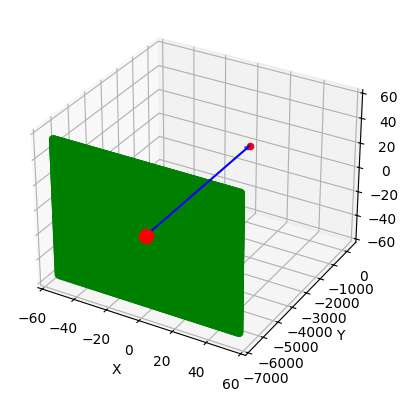

In [201]:
sphere_radius = torch.sqrt(torch.tensor(3))

# Create a 3D plot (showing only the sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
u = torch.linspace(0, 2 * np.pi, 100)
v = torch.linspace(0, np.pi, 50)
x = sphere_radius * torch.outer(torch.cos(u), torch.sin(v))
y = sphere_radius * torch.outer(torch.sin(u), torch.sin(v))
z = sphere_radius * torch.outer(torch.ones_like(u), torch.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

i = 15
ax.scatter(*geometries[i].detector_pos,color='r', label='source',s=100,zorder=3)
ax.plot(xs=[geometries[i].source_pos[0],geometries[i].detector_pos[0]],
        ys=[geometries[i].source_pos[1],geometries[i].detector_pos[1]],
        zs=[geometries[i].source_pos[2],geometries[i].detector_pos[2]],color='b',zorder=2)
ax.scatter(xs=geometries[i].detector_pixel_coordinates.view(-1,3)[:,0],
           ys=geometries[i].detector_pixel_coordinates.view(-1,3)[:,1],
           zs=geometries[i].detector_pixel_coordinates.view(-1,3)[:,2],
           color='g', label='detector',zorder=1)
ax.scatter(*geometries[i].source_pos,color='r', label='source')
plt.show()

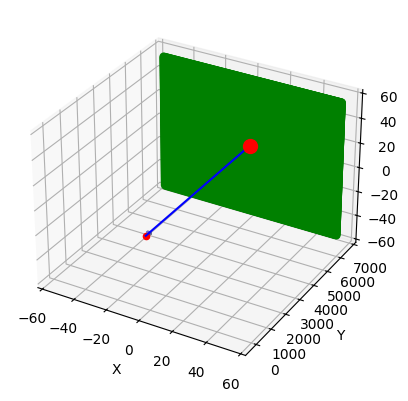

In [202]:
# Create a 3D plot (showing only the sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
u = torch.linspace(0, 2 * np.pi, 100)
v = torch.linspace(0, np.pi, 50)
x = sphere_radius * torch.outer(torch.cos(u), torch.sin(v))
y = sphere_radius * torch.outer(torch.sin(u), torch.sin(v))
z = sphere_radius * torch.outer(torch.ones_like(u), torch.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

i = 0
ax.scatter(*geometries[i].detector_pos,color='r', label='source',s=100,zorder=3)
ax.plot(xs=[geometries[i].source_pos[0],geometries[i].detector_pos[0]],
        ys=[geometries[i].source_pos[1],geometries[i].detector_pos[1]],
        zs=[geometries[i].source_pos[2],geometries[i].detector_pos[2]],color='b',zorder=2)
ax.scatter(xs=geometries[i].detector_pixel_coordinates.view(-1,3)[:,0],
           ys=geometries[i].detector_pixel_coordinates.view(-1,3)[:,1],
           zs=geometries[i].detector_pixel_coordinates.view(-1,3)[:,2],
           color='g', label='detector',zorder=1)
ax.scatter(*geometries[i].source_pos,color='r', label='source')
plt.show()

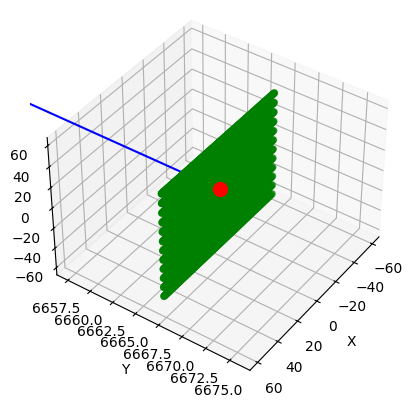

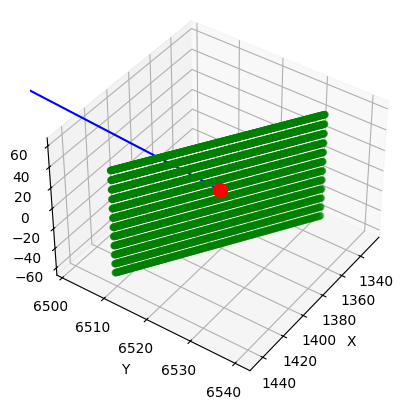

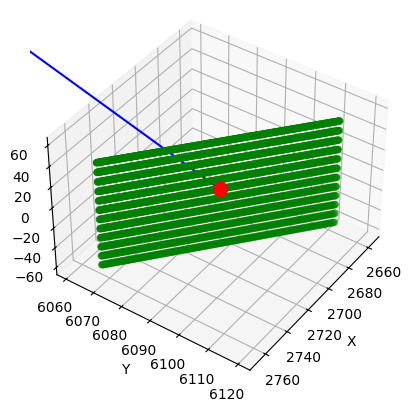

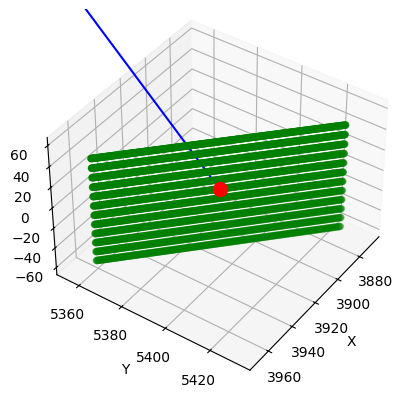

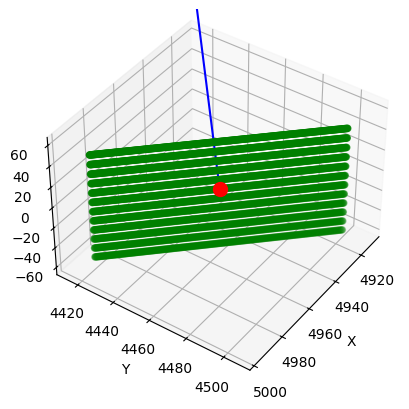

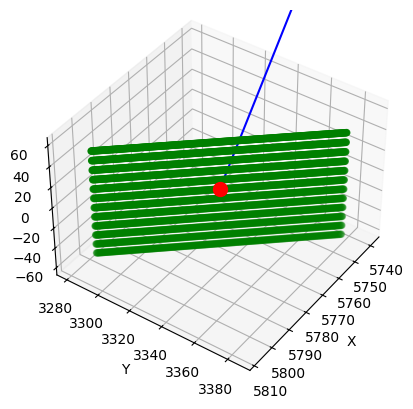

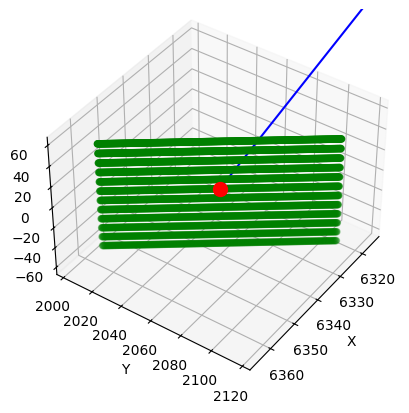

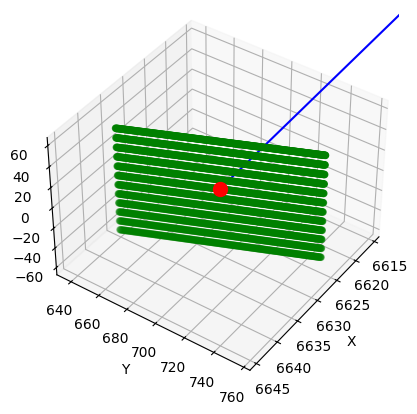

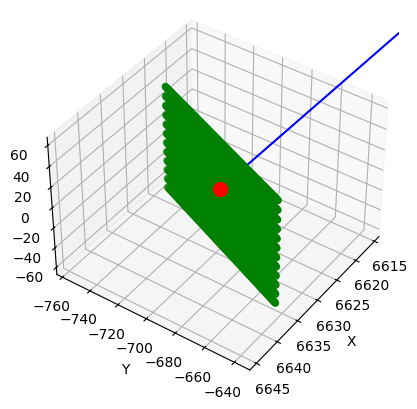

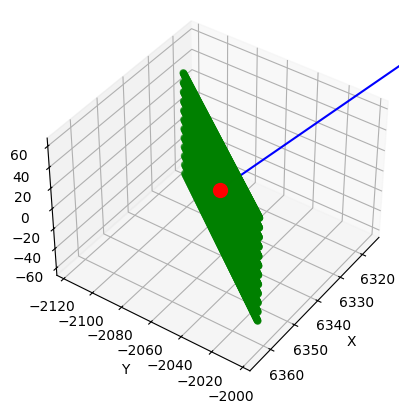

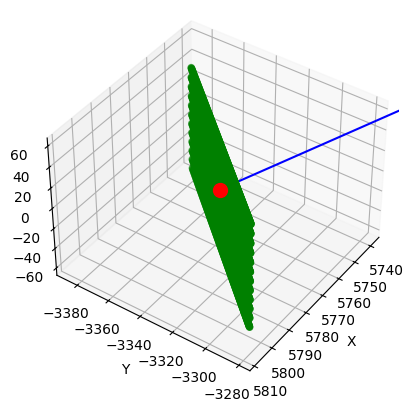

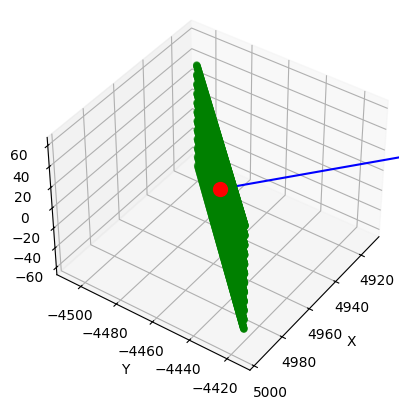

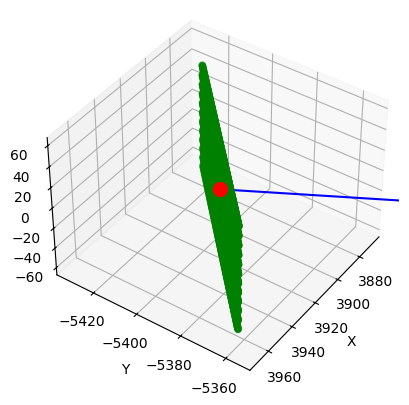

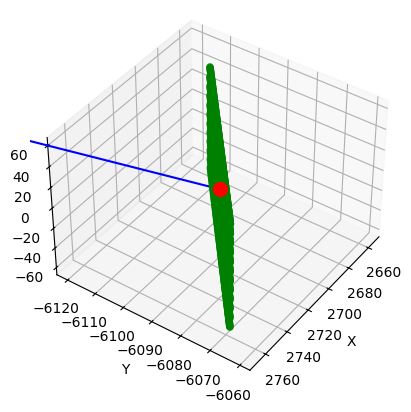

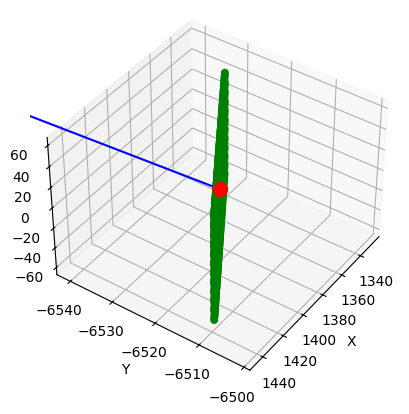

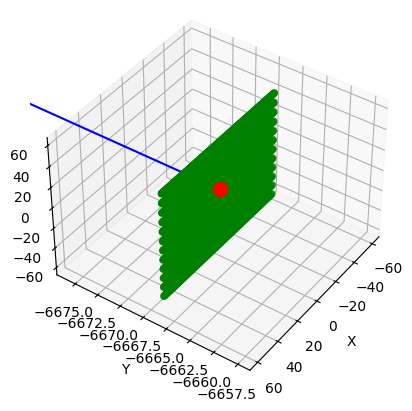

In [247]:
# Create a 3D plot (showing only the sphere)




for i in range(16):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
    # u = torch.linspace(0, 2 * np.pi, 100)
    # v = torch.linspace(0, np.pi, 50)
    # x = sphere_radius * torch.outer(torch.cos(u), torch.sin(v))
    # y = sphere_radius * torch.outer(torch.sin(u), torch.sin(v))
    # z = sphere_radius * torch.outer(torch.ones_like(u), torch.cos(v))
    # ax.plot_surface(x, y, z, color='b', alpha=0.3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(geometries[i].detector_pixel_coordinates[:,:,0].min()-10,geometries[i].detector_pixel_coordinates[:,:,0].max()+10)
    ax.set_ylim(geometries[i].detector_pixel_coordinates[:,:,1].min()-10,geometries[i].detector_pixel_coordinates[:,:,1].max()+10)
    ax.set_zlim(geometries[i].detector_pixel_coordinates[:,:,2].min()-10,geometries[i].detector_pixel_coordinates[:,:,2].max()+10)
    # ax.set_box_aspect((np.ptp(geometries[i].detector_pixel_coordinates.view(-1,3)[:,0]), np.ptp(geometries[i].detector_pixel_coordinates.view(-1,3)[:,1]), np.ptp(geometries[i].detector_pixel_coordinates.view(-1,3)[:,2])))
    
    ax.scatter(*geometries[i].detector_pos,color='r', label='source',s=100,zorder=3)
    ax.plot(xs=[geometries[i].source_pos[0],geometries[i].detector_pos[0]],
            ys=[geometries[i].source_pos[1],geometries[i].detector_pos[1]],
            zs=[geometries[i].source_pos[2],geometries[i].detector_pos[2]],color='b',zorder=0.1)
    ax.scatter(xs=geometries[i].detector_pixel_coordinates.view(-1,3)[::25,0],
               ys=geometries[i].detector_pixel_coordinates.view(-1,3)[::25,1],
               zs=geometries[i].detector_pixel_coordinates.view(-1,3)[::25,2],
               color='g', label='detector',zorder=1)
    ax.scatter(*geometries[i].source_pos,color='r', label='source')
    
    ax.view_init(elev=40, azim=35, roll=0)
    
    plt.show()

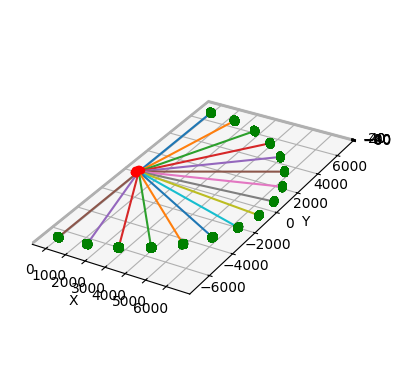

In [248]:
sphere_radius = torch.sqrt(torch.tensor(3))

# Create a 3D plot (showing only the sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u = torch.linspace(0, 2 * np.pi, 100)
v = torch.linspace(0, np.pi, 50)
x = sphere_radius * torch.outer(torch.cos(u), torch.sin(v))
y = sphere_radius * torch.outer(torch.sin(u), torch.sin(v))
z = sphere_radius * torch.outer(torch.ones_like(u), torch.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-60,60)
# ax.set_ylim(-200,7000)
# ax.set_zlim(-7000,7000)
# ax.set_box_aspect((np.ptp([-55,55]), np.ptp([-200,7000]), np.ptp([-7000,7000])))
ax.set_box_aspect((np.ptp([-200,7000]), np.ptp([-7000,7000]),np.ptp([-55,55])))


for i in range(16):
    ax.scatter(xs=geometries[i].detector_pixel_coordinates.view(-1,3)[::10,0],
               ys=geometries[i].detector_pixel_coordinates.view(-1,3)[::10,1],
               zs=geometries[i].detector_pixel_coordinates.view(-1,3)[::10,2],
               color='g', label='detector')
    ax.scatter(*geometries[i].source_pos,color='r', label='source')
    ax.plot(xs=[geometries[i].source_pos[0],geometries[i].detector_pos[0]],
            ys=[geometries[i].source_pos[1],geometries[i].detector_pos[1]],
            zs=[geometries[i].source_pos[2],geometries[i].detector_pos[2]])
plt.show()

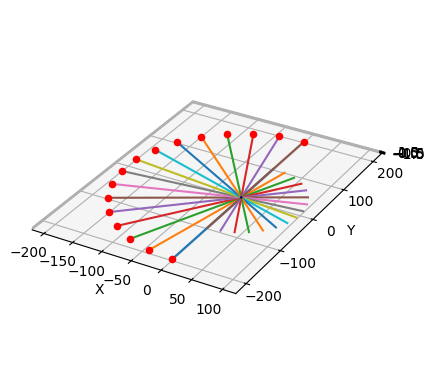

In [262]:
sphere_radius = torch.sqrt(torch.tensor(3))

# Create a 3D plot (showing only the sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u = torch.linspace(0, 2 * np.pi, 100)
v = torch.linspace(0, np.pi, 50)
x = sphere_radius * torch.outer(torch.cos(u), torch.sin(v))
y = sphere_radius * torch.outer(torch.sin(u), torch.sin(v))
z = sphere_radius * torch.outer(torch.ones_like(u), torch.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-60,60)
# ax.set_ylim(-200,7000)
# ax.set_zlim(-7000,7000)
# ax.set_box_aspect((np.ptp([-55,55]), np.ptp([-200,7000]), np.ptp([-7000,7000])))
# ax.set_box_aspect((np.ptp([-200,7000]), np.ptp([-7000,7000]),np.ptp([-55,55])))

ax.set_box_aspect((np.ptp([-210,100]), np.ptp([-210,210]),np.ptp([-2,2])))

for i in range(16):
    ax.scatter(*geometries[i].source_pos,color='r', label='source')
    direction = (geometries[i].detector_pos - geometries[i].source_pos)/ torch.linalg.norm(geometries[i].detector_pos - geometries[i].source_pos)
    ax.plot(xs=[geometries[i].source_pos[0],0,direction[0]*100],
            ys=[geometries[i].source_pos[1],0,direction[1]*100],
            zs=[geometries[i].source_pos[2],0,direction[2]*100])
plt.show()

In [256]:
(geometries[i].detector_pos - geometries[i].source_pos)/ torch.linalg.norm(geometries[i].detector_pos - geometries[i].source_pos)

tensor([ 1.2246e-16, -1.0000e+00,  0.0000e+00], dtype=torch.float64)